# Final Project


## TODO: Add project description here

In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import cv2
import matplotlib.pyplot as plt

this_dir: str = os.path.abspath('')
assets_dir: str = os.path.join(this_dir, "..", "..", "assets", "notebooks", "project")

In [2]:
# Example component

from final_project.components import FlipImageComponent


# make figure
fig = plt.figure(figsize=(16, 9), dpi=96)

# define component
flip: FlipImageComponent = FlipImageComponent(axis=0)
flip.start()

# read image from disk
image_fpath: str = os.path.join(assets_dir, "duckietown.jpg")
image: np.ndarray = cv2.imread(image_fpath)

# plot input
subfig = fig.add_subplot(1, 2, 1)
subfig.imshow(cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA))
subfig.set_title("Input")

# feed image to component
flip.in_bgr.put(image)

# get result
image2: np.ndarray = flip.out_bgr.get()

# plot output
subfig = fig.add_subplot(1, 2, 2)
subfig.imshow(cv2.cvtColor(image2, cv2.COLOR_BGRA2RGBA))
subfig.set_title("Output")

# stop component
flip.stop()

In [3]:
## Real Duckiebot only

import os
from duckietown.types import CameraParameters

os.environ.pop("DUCKIEMATRIX_ENGINE_HOST", None)

# TODO: change this to the name of your Duckiebot
VEHICLE_NAME: str = "db21j3"

CAMERA_PARAMETERS: CameraParameters = {
    "width": 640,
    "height": 480,
    "K": np.reshape(
        [
            295.79606866959824,
            0.0,
            321.2621599038631,
            0.0,
            299.5389048862878,
            241.73616515312332,
            0.0,
            0.0,
            1.0,
        ],
        (3, 3),
    ),
    "D": [
        -0.23543978771661125,
        0.03637781479419574,
        -0.0033069818601306755,
        -0.0012140708179525926,
        0.0,
    ],
    "P": np.reshape(
        [
            201.14027404785156,
            0.0,
            319.5586620845679,
            0.0,
            0.0,
            239.74398803710938,
            237.60151004037834,
            0.0,
            0.0,
            0.0,
            1.0,
            0.0,
        ],
        (3, 4),
    ),
    "H": np.reshape(
        [
            8.56148231e-03,
            2.22480148e-01,
            4.24318934e-01,
            -5.67022044e-01,
            -1.13258040e-03,
            6.81113839e-04,
            5.80917161e-02,
            4.35079347e00,
            1.0,
        ],
        (3, 3),
    ),
}

In [4]:
## Duckiematrix only

import os
os.environ["DUCKIEMATRIX_ENGINE_HOST"] = "172.17.0.1"
VEHICLE_NAME: str = "map_0/vehicle_0"

In [5]:
# Sensor - Camera

from duckietown.components.duckiebot import CameraDriverComponent

camera: CameraDriverComponent = CameraDriverComponent(vehicle_name=VEHICLE_NAME)

INFO:ControlSocket:Establishing link to CONTROL connector at tcp://172.17.0.1:7501...
INFO:DataSocket[robot]:Establishing link to DATA IN connector for group 'robot' at tcp://172.17.0.1:39981...
INFO:DataSocket[robot]:Link to DATA IN connector for group 'robot' established at tcp://172.17.0.1:39981.
INFO:DataSocket[robot]:Establishing link to DATA OUT connector for group 'robot' at tcp://172.17.0.1:35657...
INFO:DataSocket[robot]:Link to DATA OUT connector for group 'robot' established at tcp://172.17.0.1:35657.
INFO:ControlSocket:Establishing link to CONTROL connector at tcp://172.17.0.1:7501...
INFO:DataSocket[layer]:Establishing link to DATA OUT connector for group 'layer' at tcp://172.17.0.1:33791...
INFO:DataSocket[layer]:Link to DATA OUT connector for group 'layer' established at tcp://172.17.0.1:33791.


Using Duckiematrix...


In [6]:
# Image Cropping

from duckietown.components.lane_following import ImageCropComponent

image_crop: ImageCropComponent = ImageCropComponent(parameters=CAMERA_PARAMETERS)

In [7]:
# Line Detector

from duckietown.components.lane_following import LineDetectorComponent

line_detector: LineDetectorComponent = LineDetectorComponent()

In [8]:
# Lane Filter

from duckietown.components.lane_following import LaneFilterComponent

lane_filter: LaneFilterComponent = LaneFilterComponent(camera_parameters=CAMERA_PARAMETERS)

In [9]:
# Lane Controller

from duckietown.components.lane_following import LaneControllerComponent

lane_controller: LaneControllerComponent = LaneControllerComponent()

In [10]:
# Inverse Kinematics

from duckietown.components.lane_following import InverseKinematicsComponent

inverse_kinematics: InverseKinematicsComponent = InverseKinematicsComponent()

In [11]:
# PWM Mapper

from duckietown.components.lane_following import PWMComponent

pwm: PWMComponent = PWMComponent()

In [12]:
# Wheels Driver

from duckietown.components.duckiebot import MotorsDriverComponent

motors: MotorsDriverComponent = MotorsDriverComponent(vehicle_name=VEHICLE_NAME)

Using Duckiematrix...


In [13]:
# Connect components

image_crop.in_bgr.wants(camera.out_bgr)

line_detector.in_bgr.wants(image_crop.out_bgr)

lane_filter.in_lines.wants(line_detector.out_lines)
lane_filter.in_command_time.wants(motors.out_command_time)
lane_filter.in_v_omega.wants(lane_controller.out_v_omega)

lane_controller.in_d_phi.wants(lane_filter.out_d_phi)

inverse_kinematics.in_v_omega.wants(lane_controller.out_v_omega)

pwm.in_wl_wr.wants(inverse_kinematics.out_wl_wr)

motors.in_pwml_pwmr.wants(pwm.out_pwml_pwmr)

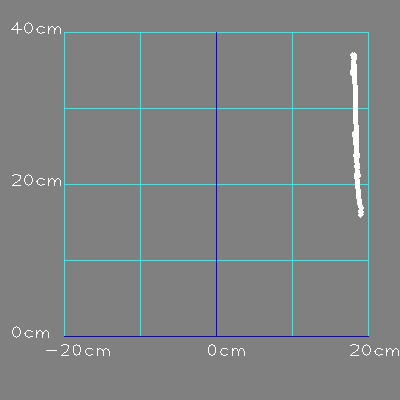

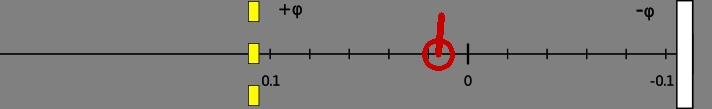

In [14]:
# Rendering components

from duckietown.components.rendering import ImageRendererComponent

# define components
segments: ImageRendererComponent = ImageRendererComponent()
belief: ImageRendererComponent = ImageRendererComponent()

# connect components
segments.in_image.wants(lane_filter.out_segments_image)
belief.in_image.wants(lane_filter.out_belief_image)

In [15]:
import time
from typing import List

from duckietown.components.base import Component
from duckietown.system import System

# list of components to run
components: List[Component] = [
    camera,
    image_crop,
    line_detector,
    lane_filter,
    lane_controller,
    inverse_kinematics,
    pwm,
    motors,
    # rendering
    segments,
    belief
]

# create system
system: System = System(components)

# run system (NOTE: this is blocking)
system.run()

[system]: System booting...
[system]: Component CameraDriverComponent@139622211809136 started!
[system]: Component ImageCropComponent@thread-13 started!
[system]: Component LineDetectorComponent@thread-14 started!
[system]: Component LaneFilterComponent@thread-15 started!
[system]: Component LaneControllerComponent@thread-16 started!
[system]: Component InverseKinematicsComponent@thread-17 started!
[system]: Component PWMComponent@thread-18 started!
[system]: Component MotorsDriverComponent@139622213850352 started!
[system]: Component ImageRendererComponent@thread-23 started!
[system]: Component ImageRendererComponent@thread-24 started!
[system]: System running...


[system]: Stopping component CameraDriverComponent@139622211809136...
[system]: Stopping component ImageCropComponent@thread-13...
[system]: Stopping component LineDetectorComponent@thread-14...
[system]: Stopping component LaneFilterComponent@thread-15...
[system]: Stopping component LaneControllerComponent@thread-16...
[system]: Stopping component InverseKinematicsComponent@thread-17...
[system]: Stopping component PWMComponent@thread-18...
[system]: Stopping component MotorsDriverComponent@139622213850352...
[system]: Stopping component ImageRendererComponent@thread-23...
[system]: Stopping component ImageRendererComponent@thread-24...
[system]: Waiting for component CameraDriverComponent@139622211809136...
[system]: Component CameraDriverComponent@139622211809136 finished
[system]: Waiting for component ImageCropComponent@thread-13...
[system]: Component ImageCropComponent@thread-13 finished
[system]: Waiting for component LineDetectorComponent@thread-14...
[system]: Component Line

In [ ]:
import threading
threading.active_count()

10